# Neural networks integration

This notebook contains a basic explanation of how neural network based models can be used within the __gojo__ library. 

In this example we will use the __Wine dataset__:

__Overview__

The Wine dataset is a classic dataset often used for classification and clustering tasks in machine learning. It contains the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The goal is to classify the wines into one of these three classes based on their chemical properties.

__Dataset Characteristics__

- **Number of Instances:** 178
- **Number of Features:** 13 numeric, predictive attributes
- **Number of Classes:** 3 (Class 0, Class 1, Class 2)

__Attribute Information__

The dataset includes 13 real-valued features for each wine sample:

1. **Alcohol**
2. **Malic acid**
3. **Ash**
4. **Alcalinity of ash**
5. **Magnesium**
6. **Total phenols**
7. **Flavanoids**
8. **Nonflavanoid phenols**
9. **Proanthocyanins**
10. **Color intensity**
11. **Hue**
12. **OD280/OD315 of diluted wines**
13. **Proline**

Each feature represents a chemical property or compound found in the wine. These features are used to classify the wine samples into one of the three cultivars.

__Target Variable__

The target variable is categorical and indicates the cultivar of the wine:

- **Class 0:** Cultivar 0
- **Class 1:** Cultivar 1
- **Class 2:** Cultivar 2

In our example we will merge classes 0 and 1 for simplicity.

__Usage__

This dataset is commonly used for:

- Classification tasks to distinguish between different wine cultivars
- Evaluating the performance of classification algorithms
- Feature selection and importance analysis
- Understanding the chemical properties that differentiate wine cultivars

__Source__

The dataset is publicly available from the UCI Machine Learning Repository and was donated by S. Aeberhard, D. Coomans, and O. de Vel from the Institute of Pharmaceutical and Food Analysis and Technologies in 1991.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# for a simpler use, we load the different submodules of the library
#     - the gojo.core module contains all the subroutines used to evaluate the models
#     - the gojo.interfaces module provides a standardized way to interact with the different elements of gojo.core
#     - the gojo.util module implements some utilities
#     - the gojo.deepl module contains all code neccessary to train deep learning models
#     - the gojo.plotting module implements different visualization tools
from gojo import core
from gojo import interfaces
from gojo import util
from gojo import deepl
from gojo import plotting

C:\Users\fgarcia\anaconda3\envs\mlv0\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load test dataset (Wine)
wine_dt = datasets.load_wine()

# create the target variable. Classification problem 0 vs rest
# to see the target names you can use wine_dt['target_names']
y = (wine_dt['target'] == 1).astype(int)  
X = wine_dt['data']

# split Xs and Ys in training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1997, shuffle=True,
    stratify=y
)

# standarize the data based on the training set statistics
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, '%.3f' % y_train.mean(),  '%.3f' % y_test.mean()

((142, 13), (36, 13), '0.401', '0.389')

## Basic model training

Let's start by training a basic model based on feed-forward networks (FFNs) without using a validation set and evaluating the performance of the model using a hold-out schema.

For the sake of simplicity, let us define the components of the FFN model one by one. Lets start with the model...

In [3]:
ffn = deepl.ffn.createSimpleFFNModel(
    in_feats=X_train.shape[1],
    out_feats=1,
    layer_dims=[20],
    layer_activation=torch.nn.ELU(),
    output_activation=torch.nn.Sigmoid())
ffn

Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
)

And now let's use the __interfaces.TorchSKInterface__ interface to create a wrapper that can be evaluated as another model in the framework.

In [4]:
model = interfaces.TorchSKInterface(
    model=ffn,
    iter_fn=deepl.iterSupervisedEpoch,
    loss_function=torch.nn.BCELoss(),
    n_epochs=150,
    optimizer_class=torch.optim.Adam,
    dataset_class=deepl.loading.TorchDataset,
    dataloader_class=torch.utils.data.DataLoader,
    optimizer_kw=dict(
        lr=0.001
    ),
    train_dataset_kw=None,
    train_dataloader_kw=dict(
        batch_size=16,
        shuffle=True
    ),
    iter_fn_kw= None,
    callbacks= None,
    seed=1997,
    device='cuda',
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5),
    verbose=1   # adjust desired verbosity level
)

model

TorchSKInterface(
    model=Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
),
    iter_fn=<function iterSupervisedEpoch at 0x000002D199195480>,
    loss_function=BCELoss(),
    n_epochs=150,
    train_split=1.0,
    train_split_stratify=False,
    optimizer_class=<class 'torch.optim.adam.Adam'>,
    dataset_class=<class 'gojo.deepl.loading.TorchDataset'>,
    dataloader_class=<class 'torch.utils.data.dataloader.DataLoader'>,
    optimizer_kw={'lr': 0.001},
    train_dataset_kw={},
    valid_dataset_kw={},
    inference_dataset_kw=None,
    train_dataloader_kw={'batch_size': 16, 'shuffle': True},
    valid_dataloader_kw={},
    inference_dataloader_kw=None,
    iter_fn_kw={},
    callbacks=None,
    metrics=[Metric(
    name=accuracy,
    function_kw={},
    multiclass=False
), Metric(
    name=balanced_accuracy,
    functio

We can now train the model by calling the train method and passing it numpy arrays

In [5]:
model.train(X_train, y_train)

Training model...: 100%|█████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 22.88it/s]


Lets analyze model convergence...

In [6]:
model_history = model.fitting_history
model_history['train'].head(5)

,epoch,loss (mean),loss (std),accuracy,balanced_accuracy,precision,recall,sensitivity,specificity,negative_predictive_value,f1_score,auc
0,0,0.639395,0.019050,0.697183,0.680599,0.629630,0.596491,0.596491,0.764706,0.738636,0.612613,0.775851
1,1,0.601799,0.012565,0.823944,0.809598,0.807692,0.736842,0.736842,0.882353,0.833333,0.770642,0.897214
2,2,0.566573,0.021680,0.880282,0.865325,0.900000,0.789474,0.789474,0.941176,0.869565,0.841121,0.950052
3,3,0.530974,0.034932,0.887324,0.874097,0.901961,0.807018,0.807018,0.941176,0.879121,0.851852,0.970072
4,4,0.498827,0.022399,0.915493,0.903406,0.941176,0.842105,0.842105,0.964706,0.901099,0.888889,0.981011


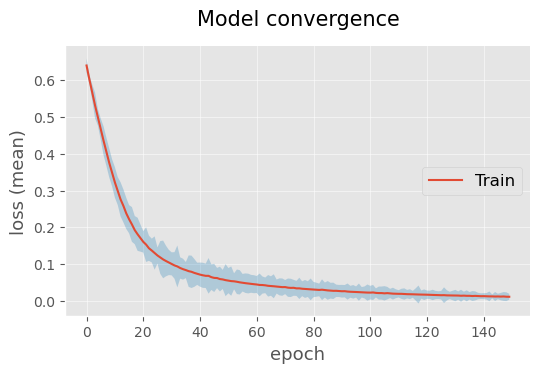

In [7]:
# display model convergence
plotting.linePlot(
    model_history['train'],
    x='epoch', y='loss (mean)', err='loss (std)',
    labels=['Train'],
    title='Model convergence',
    ls=['solid'],
    legend_pos='center right')

Since the model converges (the loss decreases asymptotically), let us evaluate the performance of the model on the test set

In [8]:
y_hat = model.performInference(X_test)

In [9]:
print('Accuracy: {:.2f}%'.format(((y_hat > 0.5).astype(int) == y_test).mean() * 100))

Accuracy: 97.22%


During model training, it is also possible to easily add a validation set to evaluate possible model overfitting. For this pourpose we can specify the parameter __train_split__ providing the proportion of samples splitted for training. In out example we also specify the parameter __train_split_stratify__ to perform the train/validation split with class stratification. The parameters of the dataset and dataloader used can also be specified by means of parameters __valid_dataset_kw__ and __valid_dataloader_kw__.

In [10]:
model_with_val = interfaces.TorchSKInterface(
    model=deepl.ffn.createSimpleFFNModel(
        in_feats=X_train.shape[1],
        out_feats=1,
        layer_dims=[20],
        layer_activation=torch.nn.ELU(),
        output_activation=torch.nn.Sigmoid()
    ),
    iter_fn=deepl.iterSupervisedEpoch,
    loss_function=torch.nn.BCELoss(),
    n_epochs=75,
    train_split=0.8,                    # (new) specify train/validation split
    train_split_stratify=True,          # (new) specify train/validation class stratification
    optimizer_class=torch.optim.Adam,
    dataset_class=deepl.loading.TorchDataset,
    dataloader_class=torch.utils.data.DataLoader,
    optimizer_kw=dict(
        lr=0.001
    ),
    train_dataset_kw=None,
    train_dataloader_kw=dict(
        batch_size=16,
        shuffle=True
    ),
    valid_dataloader_kw=dict(             # (new) validation dataloader parameters
        batch_size=X_train.shape[0]
    ),
    iter_fn_kw= None,
    callbacks= None,
    seed=1997,
    device='cuda',
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5),
    verbose=1   # adjust desired verbosity level
)

model_with_val

TorchSKInterface(
    model=Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
),
    iter_fn=<function iterSupervisedEpoch at 0x000002D199195480>,
    loss_function=BCELoss(),
    n_epochs=75,
    train_split=0.8,
    train_split_stratify=True,
    optimizer_class=<class 'torch.optim.adam.Adam'>,
    dataset_class=<class 'gojo.deepl.loading.TorchDataset'>,
    dataloader_class=<class 'torch.utils.data.dataloader.DataLoader'>,
    optimizer_kw={'lr': 0.001},
    train_dataset_kw={},
    valid_dataset_kw={},
    inference_dataset_kw=None,
    train_dataloader_kw={'batch_size': 16, 'shuffle': True},
    valid_dataloader_kw={'batch_size': 142},
    inference_dataloader_kw=None,
    iter_fn_kw={},
    callbacks=None,
    metrics=[Metric(
    name=accuracy,
    function_kw={},
    multiclass=False
), Metric(
    name=balanced_accura

In [11]:
model_with_val.train(X_train, y_train)

Training model...: 100%|███████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 48.47it/s]


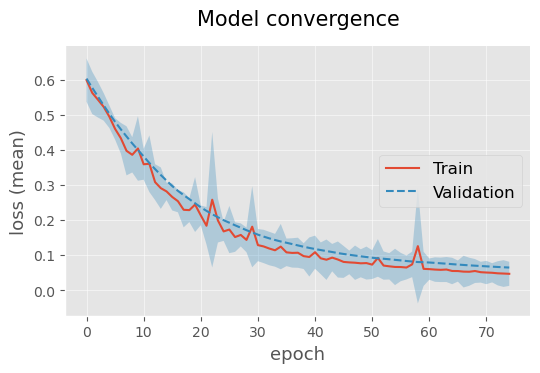

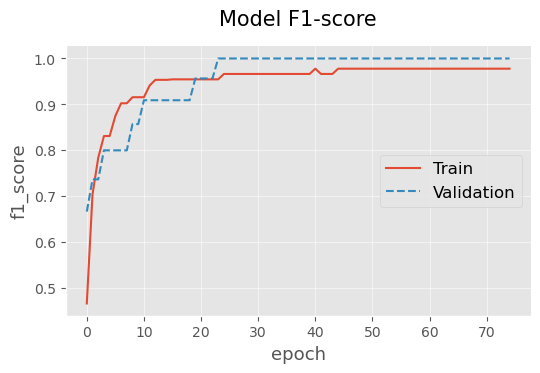

In [12]:
model_with_val_history = model_with_val.fitting_history

# display model convergence
plotting.linePlot(
    model_with_val_history['train'], model_with_val_history['valid'],
    x='epoch', y='loss (mean)', err='loss (std)',
    labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    legend_pos='center right')

# display model performance
plotting.linePlot(
    model_with_val_history['train'], model_with_val_history['valid'],
    x='epoch', y='f1_score', 
    labels=['Train', 'Validation'],
    title='Model F1-score',
    ls=['solid', 'dashed'],
    legend_pos='center right')

In [13]:
# test the model on the validation dataset
y_hat = model_with_val.performInference(X_test)
pd.DataFrame([core.getScores(y_true=y_test, y_pred=y_hat, 
               metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5))]).T.round(decimals=3)

,0
accuracy,1.0
balanced_accuracy,1.0
precision,1.0
recall,1.0
sensitivity,1.0
specificity,1.0
negative_predictive_value,1.0
f1_score,1.0
auc,1.0


## Model evaluation via cross-validation

Next, let us evaluate the model by cross-validation. In this case we will dispense with the validation set and train the model for 50 epochs evaluating its performance by 5-fold cross-validation with class stratification.

In [14]:
# This is the same definition as the previous model but we have omitted some 
# parameters that are selected by default
model_cv = interfaces.TorchSKInterface(
    model=deepl.ffn.createSimpleFFNModel(
        in_feats=X_train.shape[1],
        out_feats=1,
        layer_dims=[20],
        layer_activation=torch.nn.ELU(),
        output_activation=torch.nn.Sigmoid()
    ),
    iter_fn=deepl.iterSupervisedEpoch,
    loss_function=torch.nn.BCELoss(),
    n_epochs=50,
    optimizer_class=torch.optim.Adam,
    dataset_class=deepl.loading.TorchDataset,
    dataloader_class=torch.utils.data.DataLoader,
    optimizer_kw=dict(
        lr=0.001
    ),
    train_dataloader_kw=dict(
        batch_size=16,
        shuffle=True
    ),
    seed=1997,
    device='cuda',
)

model_cv

TorchSKInterface(
    model=Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
),
    iter_fn=<function iterSupervisedEpoch at 0x000002D199195480>,
    loss_function=BCELoss(),
    n_epochs=50,
    train_split=1.0,
    train_split_stratify=False,
    optimizer_class=<class 'torch.optim.adam.Adam'>,
    dataset_class=<class 'gojo.deepl.loading.TorchDataset'>,
    dataloader_class=<class 'torch.utils.data.dataloader.DataLoader'>,
    optimizer_kw={'lr': 0.001},
    train_dataset_kw={},
    valid_dataset_kw={},
    inference_dataset_kw=None,
    train_dataloader_kw={'batch_size': 16, 'shuffle': True},
    valid_dataloader_kw={},
    inference_dataloader_kw=None,
    iter_fn_kw={},
    callbacks=None,
    metrics=None,
    batch_size=None,
    seed=1997,
    device=cuda,
    verbose=1
)

In [15]:
# standarize the data based on the training data
zscores_scaler = interfaces.SKLearnTransformWrapper(transform_class=StandardScaler)
cv_obj = util.splitter.getCrossValObj(cv=5, repeats=1, stratified=True)

cv_report = core.evalCrossVal(
    X=X,
    y=y,
    model=model_cv,
    cv=cv_obj,
    save_train_preds=True,
    save_models=True,
    transforms=[zscores_scaler],
    n_jobs=5
)
cv_report

Performing cross-validation...: 5it [00:00, 213.13it/s]


Let's calculate the performance obtained on the test set. In this case it is important to note that the parameter __bin_threshold__ is being specified since the predictions given by the model are probabilistic and to calculate the metrics it is necessary to binarize the predictions.

In [16]:
performance = cv_report.getScores(
    core.getDefaultMetrics('binary_classification', bin_threshold=0.5), supress_warnings=True)

pd.concat([
    pd.DataFrame(performance['test'].mean(), columns=['Performance (test)']).drop(index=['n_fold']).round(decimals=3),
    pd.DataFrame(performance['train'].mean(), columns=['Performance (train)']).drop(index=['n_fold']).round(decimals=3)

], axis=1)


,Performance (test),Performance (train)
accuracy,0.978,0.996
balanced_accuracy,0.974,0.995
precision,0.987,1.000
recall,0.958,0.989
sensitivity,0.958,0.989
specificity,0.990,1.000
negative_predictive_value,0.974,0.993
f1_score,0.971,0.995
auc,0.999,1.000


Lets plot some ROC curves...

In [17]:
predictions = cv_report.getTestPredictions()
predictions.head(5)

pred_labels  true_labels
n_fold indices                          
0      14          0.000363            0
       19          0.007147            0
       20          0.046430            0
       31          0.003143            0
       36          0.022284            0

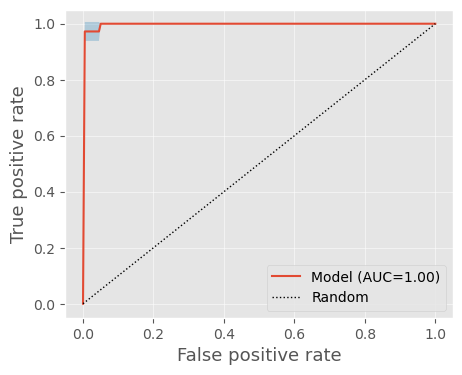

In [18]:
plotting.roc(
    df=predictions,
    y_pred='pred_labels',
    y_true='true_labels',
    average='n_fold'
    
)